In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

from tqdm.notebook import tqdm
tqdm.pandas()

from numpy import mean

import pandas as pd
import nltk
import os
import ast

from nltk import WordNetLemmatizer


In [2]:
data = pd.read_json(os.getcwd() + '/Data/CuisinePred/train.json')
train, test = train_test_split(data, train_size=0.90)

In [3]:
train.head()

,id,cuisine,ingredients
10598,30868,italian,"[black pepper, cooking spray, dry bread crumbs..."
1001,5066,cajun_creole,"[sugar, unsalted butter, lemon, all-purpose fl..."
7155,36393,southern_us,"[baking powder, yellow corn meal, all-purpose ..."
5506,34891,thai,"[curry powder, green onions, mustard greens, d..."
8782,26467,irish,"[Guinness Beer, ice cream, Irish whiskey]"


In [4]:
test.head()

,id,cuisine,ingredients
20358,10191,italian,"[sugar, olive oil, dry red wine, water, shallo..."
23294,39211,cajun_creole,"[Johnsonville Andouille, stewed tomatoes, shri..."
34749,4609,indian,"[water, paprika, serrano chile, red lentils, l..."
24752,422,japanese,"[large egg yolks, rice vinegar, kosher salt, v..."
20221,16211,jamaican,"[fresh spinach, chives, garlic, onions, chicke..."


***This has to be run only once. Once downloaded it doesn't have to be run again***

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /Users/ninja/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ninja/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/ninja/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

In [6]:
train['ingredients'] = [', '.join(ingredients).strip() for ingredients in train.ingredients]
test['ingredients'] = [', '.join(ingredients).strip() for ingredients in test.ingredients]


def text_to_wordlist(text, remove_stopwords=True, lemmatize_words=True):
    # Clean the text, with the option to remove stopwords and to stem words.

    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]

    text = ' '.join(text)
    # Optionally, shorten words to their stems
    if lemmatize_words:
        text = text.split()
        lemmatizer = WordNetLemmatizer()
        lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
        text = ' '.join(lemmatized_words)

    # Return a list of words
    return text

    
train['ingredients'] = train['ingredients'].progress_apply(text_to_wordlist)
test['ingredients'] = test['ingredients'].progress_apply(text_to_wordlist)

  0%|          | 0/35796 [00:00<?, ?it/s]

  0%|          | 0/3978 [00:00<?, ?it/s]

In [7]:
target_enc = LabelEncoder()


tfidf = TfidfVectorizer(
        stop_words=set(stopwords.words('english')),
        ngram_range = ( 1 , 1 ),
        analyzer="word", 
        max_df = .57 , 
        binary=False , 
        token_pattern=r'\w+' , 
        sublinear_tf=False
    ) 


In [8]:
X_train = train['ingredients']
y_train = target_enc.fit_transform(train['cuisine'])
X_test = test['ingredients']
y_test = target_enc.fit_transform(test['cuisine'])


In [53]:
search_space=list()

@use_named_args(search_space)
def evaluate_svc_model(**params):
	model = LinearSVC(max_iter=2000)
	model.set_params(**params)
	pipeline = Pipeline([
        ('preprocess', tfidf),    
        ('classifier', model)
        ])
	
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
	result = cross_val_score(pipeline, X_train, y_train, cv=cv, n_jobs=-1, scoring='accuracy')
	estimate = mean(result)
	
	return 1.0 - estimate

search_space.append(Real(1e-3, 1e+3, 'log-uniform', name='C'))
result_svm = gp_minimize(evaluate_svc_model, search_space)



In [11]:
print('Best Accuracy: %.3f' % (1.0 - result_svm.fun))
print('Best Parameters: %s' % (result_svm.x))

Best Accuracy: 0.792
Best Parameters: [0.3072715977398071]


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

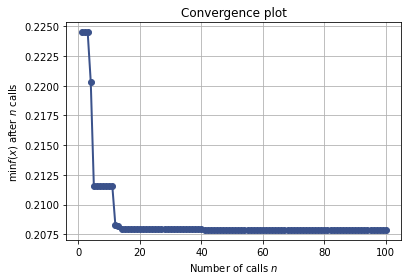

In [12]:
from skopt.plots import plot_convergence

plot_convergence(result_svm)

In [54]:
lr_space = list()

@use_named_args(lr_space)
def evaluate_lr_model(**params):
	model = LogisticRegression(dual=False)
	model.set_params(**params)
	pipeline = Pipeline([
        ('preprocess', tfidf),    
        ('classifier', model)
        ])
	
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	result = cross_val_score(pipeline, X_train, y_train, cv=cv, n_jobs=-1, scoring='accuracy')
	estimate = mean(result)
	
	return 1.0 - estimate

lr_space.append(Real(1e-3, 1e+3, 'log-uniform', name='C'))
result_lr = gp_minimize(evaluate_lr_model, lr_space)


In [16]:
print('Best Accuracy: %.3f' % (1.0 - result_lr.fun))
print('Best Parameters: %s' % (result_lr.x))

Best Accuracy: 0.792
Best Parameters: [3.729775083769648]


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

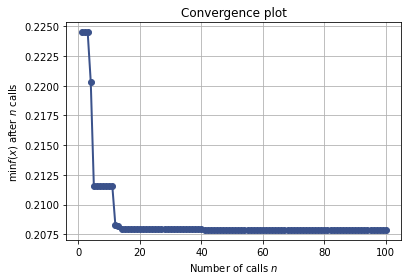

In [17]:
plot_convergence(result_svm)

In [11]:
model = LinearSVC(max_iter=2000, C=0.3072715977398071)
pipeline = Pipeline([
        ('preprocess', tfidf),    
        ('classifier', model)
        ])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 TfidfVectorizer(max_df=0.57,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...},
                                 token_pattern='\\w+')),
                ('classifier', LinearSVC(C=0.3072715977398071, max_iter=2000))])

In [37]:
preds = pipeline.predict(X_test)
preds = target_enc.inverse_transform(preds)

In [38]:
print('Acuracy: ', (test.cuisine == preds).sum()/len(test))

0.7976370035193565

In [14]:
from joblib import dump, load
dump(pipeline, 'Model/cuisine_predictor.joblib') 

['cuisine_predictor.joblib']

In [21]:
recipes_path = os.getcwd() + '/Data/full_recipes.csv'

In [22]:
recipes = pd.read_csv(recipes_path)
recipes.head()

,name,id,contributor_id,n_steps,steps,ingredients,n_ingredients,nutrition
0,arriba baked winter squash mexican style,137739,47892,11,"['make a choice and proceed with recipe', 'dep...","['winter squash', 'mexican seasoning', 'mixed ...",7,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]"
1,a bit different breakfast pizza,31490,26278,9,"['preheat oven to 425 degrees f', 'press dough...","['prepared pizza crust', 'sausage patty', 'egg...",6,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]"
2,all in the kitchen chili,112140,196586,6,"['brown ground beef in large pot', 'add choppe...","['ground beef', 'yellow onions', 'diced tomato...",13,"[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]"
3,alouette potatoes,59389,68585,11,['place potatoes in a large pot of lightly sal...,"['spreadable cheese with garlic and herbs', 'n...",11,"[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]"
4,amish tomato ketchup for canning,44061,41706,5,['mix all ingredients& boil for 2 1 / 2 hours ...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,"[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]"


In [47]:
recipes['ingredients_list'] = recipes['ingredients'].apply(ast.literal_eval)
recipes['ingredient_features'] = [', '.join(ingredients).strip() for ingredients in recipes['ingredients_list']]
recipes['ingredient_features'] = recipes['ingredient_features'].progress_apply(text_to_wordlist)

ing_pred = recipes['ingredient_features']

  0%|          | 0/231637 [00:00<?, ?it/s]

In [48]:
cuisine_preds = pipeline.predict(ing_pred)
cuisine_pred_labels = target_enc.inverse_transform(cuisine_preds)

In [49]:
recipes['cuisine'] = cuisine_pred_labels
recipes = recipes.drop(columns=['ingredients_list', 'ingredient_features'])

In [25]:
recipes.head()

,name,id,contributor_id,n_steps,steps,ingredients,n_ingredients,nutrition,cuisine
0,arriba baked winter squash mexican style,137739,47892,11,"['make a choice and proceed with recipe', 'dep...","['winter squash', 'mexican seasoning', 'mixed ...",7,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",southern_us
1,a bit different breakfast pizza,31490,26278,9,"['preheat oven to 425 degrees f', 'press dough...","['prepared pizza crust', 'sausage patty', 'egg...",6,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",italian
2,all in the kitchen chili,112140,196586,6,"['brown ground beef in large pot', 'add choppe...","['ground beef', 'yellow onions', 'diced tomato...",13,"[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",mexican
3,alouette potatoes,59389,68585,11,['place potatoes in a large pot of lightly sal...,"['spreadable cheese with garlic and herbs', 'n...",11,"[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",french
4,amish tomato ketchup for canning,44061,41706,5,['mix all ingredients& boil for 2 1 / 2 hours ...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,"[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",southern_us


In [24]:
write_path = os.getcwd() + '/Data/recipes_enriched.csv'
recipes.to_csv(write_path, index=False)